In [45]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from pathlib import Path 
import matplotlib.pyplot as plt

In [46]:
carrier_mapper = {
    "PHS": "hydro",
    "hydro-scheme": "hydro",
    "hydro": "hydro",
    "dam": "hydro",
    "PHS": "hydro",
    "floating wind": "wind",
    "onwind": "wind",
    "wind": "wind",
    "offwind": "wind",
    "CCGT": "gas",
    "CHP": "gas",
    "biomass": "biomass",
    "gas": "gas",
    "gas-fired": "gas",
    "gas turbine": "gas",
    "coal": "coal",
    "powerstation": "gas",
    "cascade": "gas",
    "nuclear": "nuclear",
    "battery": "battery",
    'interconnector': 'imports',
    'PV': 'solar',
    'solar power station': 'solar',
}

In [47]:
carrier_colors = {
    "wind": "#7ac677",
    "offshore wind": "#6895dd",
    "hydro": "purple",
    "coal": "#454546",
    "biomass": "#dbc263",
    "gas": "#f6986b",
    "nuclear": '#549ca2',
    "imports": "#dd75b0",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": 'turquoise',
}

In [48]:
bids = []

# start = pd.Timestamp('2022-01')
# end = pd.Timestamp('2022-07-01')

for d in tqdm(os.listdir(Path.cwd().parent / 'data' / 'base')):

    # ts = pd.Timestamp(d)
    # if ts < start or ts > end:
    #     continue

    try:
        bids.append(
            pd.read_csv(
                Path.cwd().parent / 'data' / 'base' / d / 'bids.csv', index_col=[0,1]
            )
        )

    except FileNotFoundError:
        pass

bids = pd.concat(bids)

  0%|          | 0/631 [00:00<?, ?it/s]

100%|██████████| 631/631 [00:03<00:00, 202.64it/s]


In [49]:
bmus = pd.read_csv(Path.cwd().parent / 'data' / 'temp_located_bmus.csv', index_col=0)
bmus = bmus.loc[bmus['lat'] != 0.]

In [52]:
idx = pd.IndexSlice

bid_prices = bids.loc[idx[:,'price'],:]

bid_acceptances = len(bid_prices) - bid_prices.isna().sum()

thresh = 48

bid_acceptances = bid_acceptances.loc[bid_acceptances > thresh].index

In [76]:
cfd = pd.read_csv(Path.cwd().parent / 'resources' / 'cfd_strike_prices.csv', index_col=0).index

In [78]:
bid_stats = pd.concat((
    bid_prices.mean().rename('mean'),
    bid_prices.std().rename('std')),
    axis=1).loc[bid_acceptances]
bid_stats = bid_stats.loc[bid_stats.index.intersection(bmus.index)]
bid_stats.sort_values('std', ascending=True, inplace=True)
bid_stats['carrier'] = list(map(lambda name: bmus.loc[name, 'carrier'], bid_stats.index))
# bid_stats.drop(cfd.intersection(bid_stats.index), inplace=True)

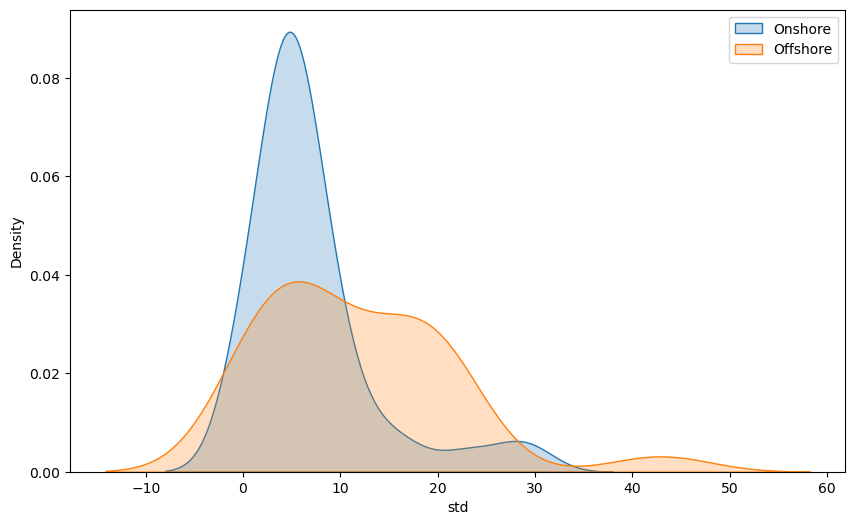

In [75]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))

# wind_rocs = bid_stats.loc[bid_stats['carrier'].str.contains('wind')]
wind_rocs = bid_stats.loc[bid_stats['carrier'] == 'onwind']
sns.kdeplot(wind_rocs['std'], cmap='viridis', fill=True, ax=ax, label='Onshore')

wind_rocs = bid_stats.loc[bid_stats['carrier'] == 'offwind']
# sns.kdeplot(wind_rocs['mean'], cmap='viridis', shade=True, shade_lowest=False, ax=ax, label='Offshore')
sns.kdeplot(wind_rocs['std'], cmap='viridis', fill=True, ax=ax, label='Offshore')

ax.legend()
plt.show()

In [64]:
b = bmus.dropna()
b = b.loc[b['carrier'].str.contains('wind')]
b.drop(cfd.intersection(b.index), inplace=True)

b

,lat,lon,capacity,carrier
NationalGridBmUnit,,,,
CMSTW-1,58.406935,-3.270129,50.0,onwind
ROTHW-1,57.530000,-3.360000,0.0,onwind
PAUHW-1,57.451933,-3.458196,65.0,onwind
CAIRW-2,57.504968,-3.063895,0.0,onwind
MDHLW-1,56.964685,-2.482026,75.9,onwind
...,...,...,...,...
FSDLW-1,55.780803,-5.479859,22.5,onwind
MYGPW-1,55.248768,-3.514802,25.0,onwind
OMNDO-1,54.100000,-3.400000,150.0,offwind


In [ ]:
from scipy.stats import norm


In [34]:
w = bid_stats.dropna().loc[bid_stats.dropna()['carrier'].str.contains('wind')]

print(w.loc[cfd.intersection(w.index), ['mean', 'std']].mean())
print(w.drop(cfd.intersection(w.index))[['mean', 'std']].mean())

mean    77.812871
std     36.850208
dtype: float64
mean    91.757643
std      8.071386
dtype: float64


In [99]:
import numpy as np
from scipy import stats, optimize

def estimate_normal_params_truncated(data, truncation_quantile=0.7):
    """
    Estimate the parameters of an original normal distribution given data
    truncated at a specified quantile.

    Parameters:
    - data: array-like, the observed truncated data
    - truncation_quantile: float, the quantile at which the data is truncated (default is 0.7)

    Returns:
    - mu_est: float, estimated mean of the original normal distribution
    - sigma_est: float, estimated standard deviation of the original normal distribution
    """
    mu_init = np.mean(data)
    sigma_init = np.std(data, ddof=1)
    params_init = [mu_init, sigma_init]
    print(params_init)

    truncation_point = stats.norm.ppf(truncation_quantile)

    def neg_log_likelihood(params):
        mu, sigma = params
        if sigma <= 0:
            return np.inf  # sigma must be positive
        pdf_vals = stats.norm.pdf(data, loc=mu, scale=sigma)
        cdf_trunc = stats.norm.cdf(truncation_point, loc=mu, scale=sigma)
        # Avoid log(0) by adding a small epsilon
        epsilon = 1e-9
        pdf_vals = np.maximum(pdf_vals, epsilon)
        cdf_trunc = max(cdf_trunc, epsilon)
        nll = -np.sum(np.log(pdf_vals)) + len(data) * np.log(cdf_trunc)
        return nll

    result = optimize.minimize(
        neg_log_likelihood,
        params_init,
        method='L-BFGS-B',
        bounds=[(None, None), (1e-6, None)]
    )

    if result.success:
        mu_est, sigma_est = result.x
        return mu_est, sigma_est
    else:
        raise RuntimeError("Optimization failed: " + result.message)

# Example usage:
np.random.seed(0)
true_mu = 0
true_sigma = 1
sample_size = 1000
full_data = np.random.normal(loc=true_mu, scale=true_sigma, size=sample_size)
truncation_quantile = 0.7
truncation_point = stats.norm.ppf(truncation_quantile, loc=true_mu, scale=true_sigma)
truncated_data = full_data[full_data <= truncation_point]

mu_est, sigma_est = estimate_normal_params_truncated(truncated_data, truncation_quantile)

print(f"Estimated mu: {mu_est}")
print(f"Estimated sigma: {sigma_est}")
print(f"True mu: {true_mu}")
print(f"True sigma: {true_sigma}")


[-0.49229321618158256, 0.6996385062751899]
Estimated mu: 0.003231730203075673
Estimated sigma: 0.9963055023474329
True mu: 0
True sigma: 1


103 roc plants of carrier onwind
if those, we have 91 available
0.883495145631068
[78.187255866967, 19.426564733626297]
83.0077127608546 13.640830850438137
99.27633709657451
78.187255866967 19.4265647336263
number of needed roc values: 12
103.60590003143686 3.258010953127529


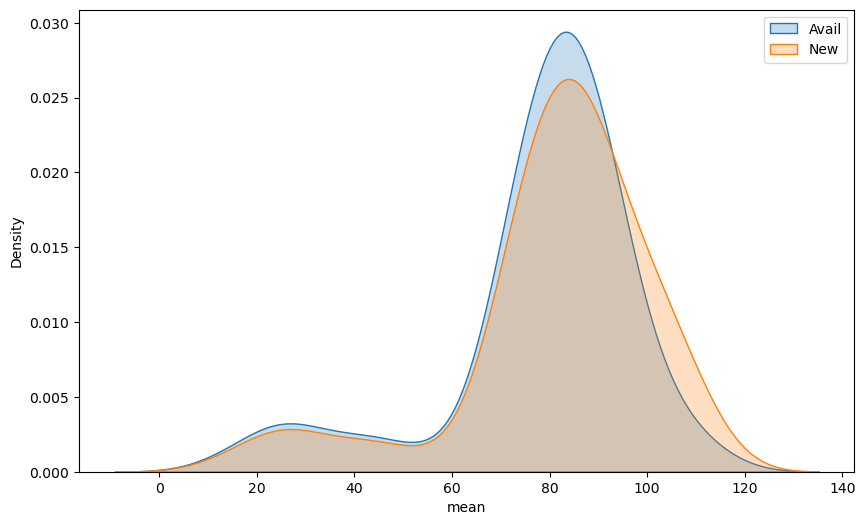

51 roc plants of carrier offwind
if those, we have 44 available
0.8627450980392157
[112.51144326755879, 46.753253638358096]
128.33355161026253 21.2145564890948
151.51545757642216
112.51144326755879 46.75325363835809
number of needed roc values: 7
160.86200161877673 7.037300595811823


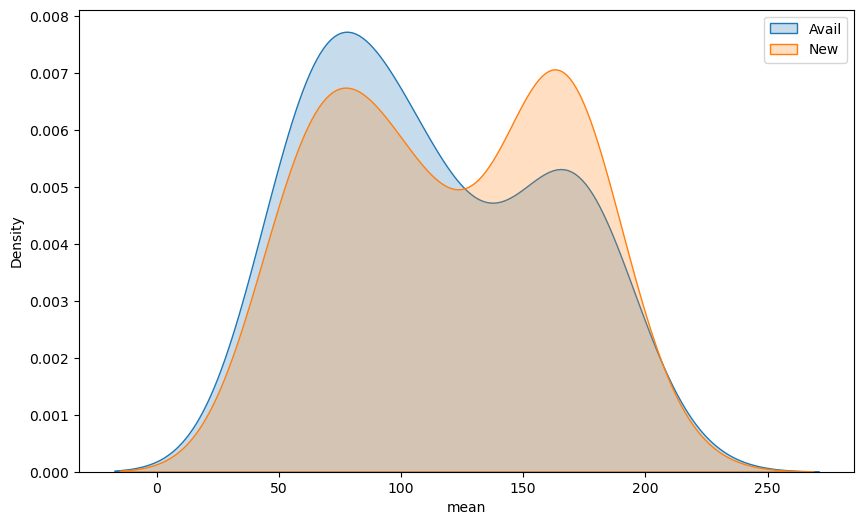

In [112]:


for carrier in ['onwind', 'offwind']:

    all_roc_plants = bmus.loc[bmus['carrier'] == carrier]
    all_roc_plants = all_roc_plants.drop(all_roc_plants.index.intersection(cfd))

    print('{} roc plants of carrier {}'.format(len(all_roc_plants), carrier))
    
    roc_avail = bid_stats.loc[bid_stats['carrier'] == carrier]
    roc_avail = roc_avail.loc[roc_avail.index.intersection(bmus.index)]
    print('if those, we have {} available'.format(len(roc_avail)))

    truncation_quantile = len(roc_avail) / len(all_roc_plants)
    print(truncation_quantile)

    mu_est, sigma_est = estimate_normal_params_truncated(
        roc_avail['mean'].values,
        truncation_quantile
        )

    print(mu_est, sigma_est)

    ppf = stats.norm.ppf(truncation_quantile, loc=mu_est, scale=sigma_est)    

    print(ppf)

    needed = len(all_roc_plants) - len(roc_avail)

    sample_roc = np.random.normal(size=1000, loc=mu_est, scale=sigma_est)
    sample_roc = sample_roc[sample_roc >= ppf][:needed]

    print(roc_avail['mean'].mean(), roc_avail['mean'].std())
    print('number of needed roc values: {}'.format(needed))

    print(sample_roc.mean(), sample_roc.std())

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.kdeplot(roc_avail['mean'], fill=True, ax=ax, label='Avail')
    sns.kdeplot(roc_avail['mean'].tolist() + list(sample_roc), fill=True, ax=ax, label='New')

    ax.legend()

    plt.show()




In [84]:
roc_avail['mean'].values

array([100.        ,  75.        ,  71.5       ,  75.        ,
        88.        ,  90.        ,  88.        ,  88.        ,
        94.77      ,  84.64      ,  76.06289077,  20.36501846,
        73.65133005,  72.25731895,  75.99389228,  82.10309295,
        77.16874541, 111.41437318,  72.44379845,  91.58917582,
        93.04944659,  86.8334647 ,  29.47709782,  95.33528986,
        94.68411504,  89.47678211,  84.47114625,  92.99697034,
        84.89645777,  86.34645646,  89.90392351,  86.97552989,
        90.06952381,  85.66873348,  83.64427861,  84.27789623,
        90.57701863,  91.58277445,  85.55562035,  86.26526502,
        67.6310559 ,  91.7307947 ,  78.89904953,  86.25494205,
        74.95541401,  90.95538365,  75.37029915,  94.04659574,
        78.12030075,  86.13116025,  89.48345936,  74.53528753,
        81.91519869,  81.13721829,  77.6963761 ,  80.64051759,
        70.20714572,  77.79947772,  71.04814522,  81.19382319,
        14.56844533,  79.12651753,  79.03196813,  85.92